# Lets compare to Pythologist to IrisSpatialFeatures

In [15]:
from pythologist_test_images import TestImages
from pythologist_reader.formats.inform.custom import CellProjectInFormLineArea
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import os
from tempfile import NamedTemporaryFile

#cdf = TestImages().celldataframe('IrisSpatialFeatures')
f = NamedTemporaryFile()
cpi = CellProjectInFormLineArea(f.name,mode='w')
cpi.read_path(TestImages().raw('IrisSpatialFeatures'),
              steps=76,
              project_name='MEL',
              sample_name_index=-1,
              microns_per_pixel=0.496)
cdf = cpi.cdf
os.unlink(f.name)
cdf['frame_name'] = cdf['frame_name'].apply(lambda x: x.split('_')[-1]).astype(int)
base = TestImages().r_irisspatialfeatures_path

## Count densities

### Compare per-Frame Count Densities

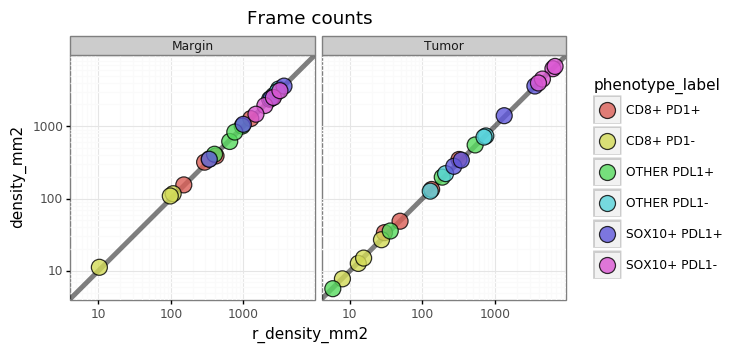

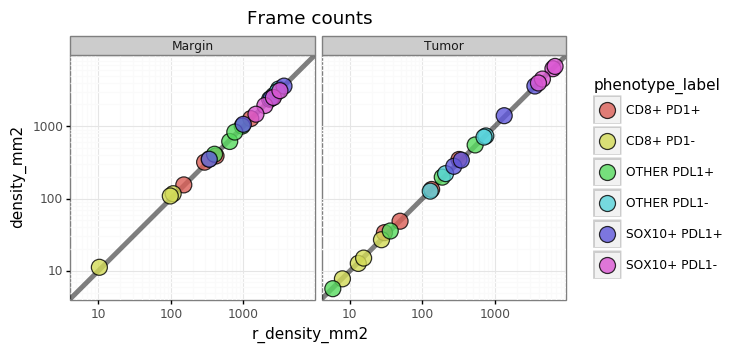

In [16]:
# read R data
infile = os.path.join(base,'frame_counts.csv')
r_frame_counts = pd.read_csv(infile)
thresh = cdf.threshold('SOX10+','PDL1').threshold('CD8+','PD1').threshold('OTHER','PDL1')
frame_counts = thresh.counts().frame_counts()
# compare the R and python
df = r_frame_counts.rename(columns={'density_mm2':'r_density_mm2'}).\
    merge(frame_counts[['sample_name','frame_name','region_label','density_mm2','phenotype_label']],
          on=['sample_name','frame_name','region_label','phenotype_label'],how='outer').fillna(0)
df = df.loc[df['region_label']!='Stroma'] # code doesn't catch stroma
temp = df.copy()
temp['density_mm2'] = temp['density_mm2'].add(1)
temp['r_density_mm2'] = temp['r_density_mm2'].add(1)
g = (ggplot(temp,aes(x='r_density_mm2',y='density_mm2',fill='phenotype_label'))
 + geom_abline(slope=1,alpha=0.5,size=2)
 + geom_point(size=6,alpha=0.8)
 + facet_wrap(['region_label'])
 + theme_bw()
 + theme(aspect_ratio=1)
 + scale_x_log10()
 + scale_y_log10()
 + ggtitle('Frame counts')
)
g.draw()

### Compare per-Sample Count Densities

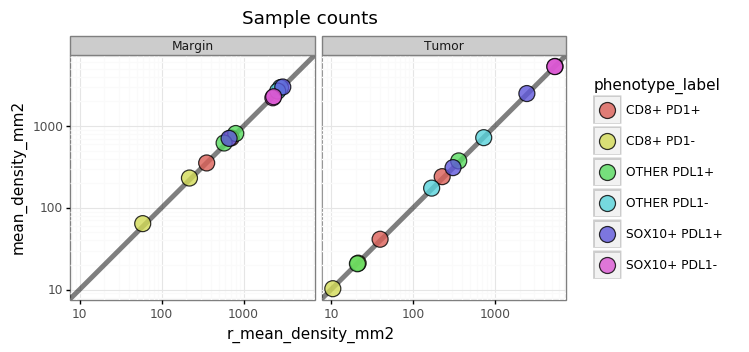

In [17]:
# Compare Sample Counts
plt.show()
# read R data
infile = os.path.join(base,'sample_counts.csv')
r_sample_counts = pd.read_csv(infile)
r_sample_counts
sample_counts = thresh.counts().sample_counts()
# compare the R and python
df = r_sample_counts.rename(columns={'mean_density_mm2':'r_mean_density_mm2'}).\
    merge(sample_counts[['sample_name','region_label','mean_density_mm2','phenotype_label']],
          on=['sample_name','region_label','phenotype_label'],how='outer').fillna(0)
df = df.loc[df['region_label']!='Stroma'] # code doesn't catch stroma
temp = df.copy()
temp['mean_density_mm2'] = temp['mean_density_mm2'].add(1)
temp['r_mean_density_mm2'] = temp['r_mean_density_mm2'].add(1)
g = (ggplot(temp,aes(x='r_mean_density_mm2',y='mean_density_mm2',fill='phenotype_label'))
 + geom_abline(slope=1,alpha=0.5,size=2)
 + geom_point(size=6,alpha=0.8)
 + facet_wrap(['region_label'])
 + theme_bw()
 + theme(aspect_ratio=1)
 + scale_x_log10()
 + scale_y_log10()
 + ggtitle('Sample counts')
)
g.draw()
plt.show()

## Cell-Cell Contacts

### Compare per-Sample cell-cell contact densities

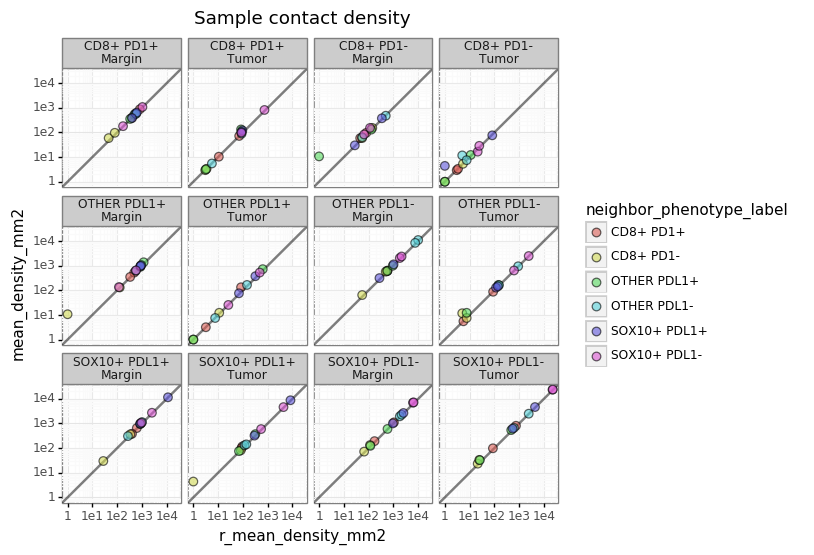

In [18]:
infile = os.path.join(base,'sample_contact_density.csv')
r_sample_contact_density = pd.read_csv(infile)
r_sample_contact_density.head()
sample_contact_density = thresh.contacts().sample_counts()
sample_contact_density = sample_contact_density.loc[sample_contact_density['region_label']!='Stroma']
sample_contact_density.head()
df = r_sample_contact_density.rename(columns={'mean_interaction_density_mm2':'r_mean_density_mm2'}).\
    merge(sample_contact_density[['sample_name',
                                  'region_label',
                                  'mean_density_mm2',
                                  'phenotype_label',
                                  'neighbor_phenotype_label']],
          on=['sample_name','region_label','phenotype_label','neighbor_phenotype_label'],how='outer').fillna(0)
temp = df.copy()
temp['mean_density_mm2'] = temp['mean_density_mm2'].add(1)
temp['r_mean_density_mm2'] = temp['r_mean_density_mm2'].add(1)
g = (ggplot(temp,aes(x='r_mean_density_mm2',y='mean_density_mm2',fill='neighbor_phenotype_label'))
 + geom_abline(slope=1,alpha=0.5,size=1)
 + geom_point(size=3,alpha=0.6)
 + facet_wrap(['phenotype_label','region_label'])
 + theme_bw()
 + theme(aspect_ratio=1)
 + scale_x_log10()
 + scale_y_log10()
 + ggtitle('Sample contact density')
)
g.draw()
plt.show()

### Compare per-Sample cell-cell contact fractions

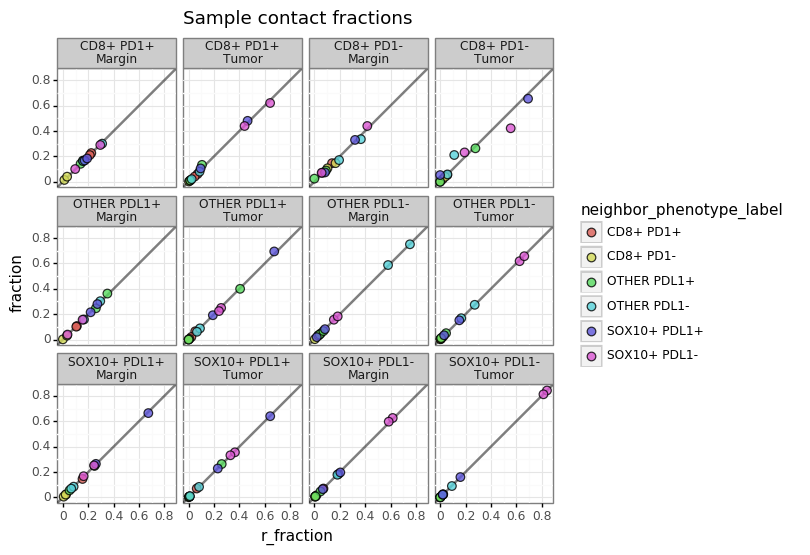

In [19]:
infile = os.path.join(base,'sample_contact_fractions.csv')
r_sample_contact_fractions = pd.read_csv(infile)
sample_contact_fractions = thresh.contacts().sample_proportions()
sample_contact_fractions = sample_contact_fractions.loc[sample_contact_fractions['region_label']!='Stroma']
sample_contact_fractions.head()
df = r_sample_contact_fractions.rename(columns={'fraction':'r_fraction'}).\
    merge(sample_contact_fractions[['sample_name',
                                  'region_label',
                                  'fraction',
                                  'phenotype_label',
                                  'neighbor_phenotype_label']],
          on=['sample_name','region_label','phenotype_label','neighbor_phenotype_label'],how='outer').fillna(0)
temp = df.copy()
#temp = temp.loc[temp['phenotype_label']=='OTHER PDL1-']
g = (ggplot(temp,aes(x='r_fraction',y='fraction',fill='neighbor_phenotype_label'))
 + geom_abline(slope=1,alpha=0.5,size=1)
 + geom_point(size=3,alpha=0.8)
 + facet_wrap(['phenotype_label','region_label'])
 + theme_bw()
 + theme(aspect_ratio=1)
 + ggtitle('Sample contact fractions')
 + xlim(0,0.85)
 + ylim(0,0.85)
)
g.draw()
plt.show()

## Nearest Neighbor 

### Compare per-Sample nearest neighbor distances

⚠️ The consistency of the R scripts use of `NaN` and `0` is a bit suspect here. The intention was for `NaN` to be used when insufficient data based on a minimum number of cells with a phenotype being present.  For plotting purposes, we will plot NaN values as -20 and a maximum of 100um distance.  Here we have switched to use a `minimum_edges` parameter to descide whether or not to include a measurement. The proceedure for how to aggregate the nearest neighbor distances and when to decide if there is enough info could use a closer look.

/Users/jasonweirather/miniconda3/lib/python3.7/site-packages/plotnine/scales/scales.py:28: UserWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

  warn(_TPL_DUPLICATE_SCALE.format(ae))
/Users/jasonweirather/miniconda3/lib/python3.7/site-packages/plotnine/scales/scales.py:28: UserWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

  warn(_TPL_DUPLICATE_SCALE.format(ae))
/Users/jasonweirather/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 20 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


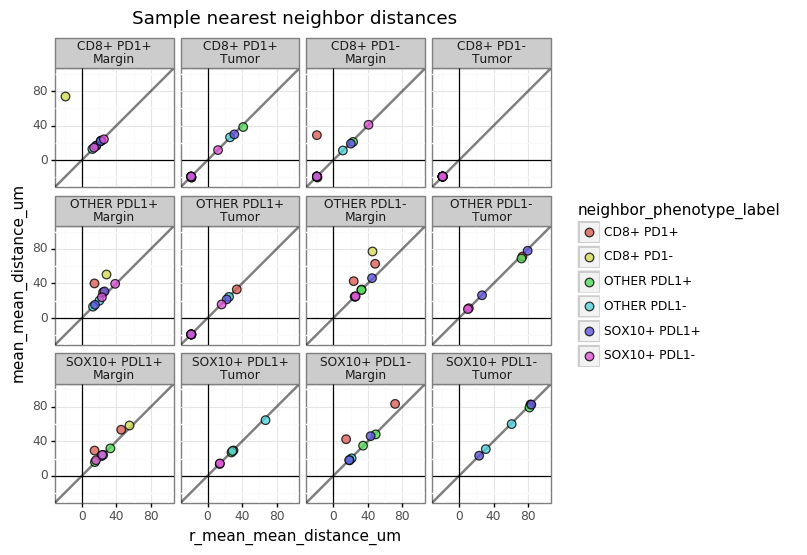

In [20]:
infile = os.path.join(base,'sample_nn.csv')
r_nn = pd.read_csv(infile)
thresh2 = thresh.loc[thresh['region_label']!='Stroma']
nn = thresh2.nearestneighbors().sample_distance(minimum_edges=20)
df = r_nn.rename(columns={'mean_distance_um':'r_mean_mean_distance_um'}).\
    merge(nn[['sample_name',
              'region_label',
              'mean_mean_distance_um',
              'phenotype_label',
              'neighbor_phenotype_label']],
          on=['sample_name','region_label','phenotype_label','neighbor_phenotype_label'],how='outer').fillna(-20)
df=df.loc[df['region_label']!='Stroma']
temp = df.copy()
temp = temp.loc[temp['r_mean_mean_distance_um']!=0]
temp['mean_mean_distance_um'] = temp['mean_mean_distance_um'].add(1)
temp['r_mean_mean_distance_um'] = temp['r_mean_mean_distance_um'].add(1)
g = (ggplot(temp,aes(x='r_mean_mean_distance_um',y='mean_mean_distance_um',fill='neighbor_phenotype_label'))
 + geom_abline(slope=1,alpha=0.5,size=1)
 + geom_point(size=3,alpha=0.8)
 + geom_vline(xintercept=0)
 + geom_hline(yintercept=0)
 + facet_wrap(['phenotype_label','region_label'])
 + theme_bw()
 + theme(aspect_ratio=1)
 + ggtitle('Sample nearest neighbor distances')
 + scale_x_log10()
 + scale_y_log10()
 + xlim(-25,100)
 + ylim(-25,100)
)
g.draw()
plt.show()